In [26]:
import pandas as pd
import geopandas as gpd
from glob import glob
import os

# get path of current file
path = os.path.dirname(os.getcwd())
dir_data = os.path.join(path, "data")


In [27]:
# pull spend from Dewey

import pandas as pd
import numpy as np
import json
import base64
import requests
from bs4 import BeautifulSoup


un = "dvdijcke@umich.edu" # Set username
pw = "98Manor&Thread" # Set password

credentials = f"{un}:{pw}" # Format credentials according to the API's expectations
print(credentials)

# convert to base64
credentials_bytes = credentials.encode('ascii')
base64_credentials_bytes = base64.b64encode(credentials_bytes)
base64_credentials = base64_credentials_bytes.decode('ascii')
print(base64_credentials)

# request access token
headers = {
    'accept': 'application/json',
    'Authorization': f'Basic {base64_credentials}'
}

response = requests.post("https://marketplace.deweydata.io/api/auth/tks/get_token", headers=headers)
print(response.json())
access_token = response.json()['access_token']
print(access_token)

# request file list
headers = {
    'accept': 'application/json',
    'Authorization': f'Bearer {access_token}'
}

url = "https://marketplace.deweydata.io/api/data/v2/list/"
response = requests.get(url, headers=headers)
response.json()

dvdijcke@umich.edu:98Manor&Thread
ZHZkaWpja2VAdW1pY2guZWR1Ojk4TWFub3ImVGhyZWFk
{'access_token': 'syS7aJKF1K65lQisR8WGnm9NTTc', 'expires_in': 26753, 'token_type': 'bearer', 'refresh_token': 'Evf5gaUh88-SY20ahNz72xHDhv8'}
syS7aJKF1K65lQisR8WGnm9NTTc


[{'name': '2023',
  'parent': '/api/data/v2/list',
  'url': '/api/data/v2/list/2023',
  'size': 0,
  'createdAt': '2023-01-01T00:00:00',
  'updatedAt': '2023-02-09T00:00:00',
  'directory': True,
  'writable': False},
 {'name': '2022',
  'parent': '/api/data/v2/list',
  'url': '/api/data/v2/list/2022',
  'size': 0,
  'createdAt': '2022-01-01T00:00:00',
  'updatedAt': '2022-12-31T00:00:00',
  'directory': True,
  'writable': False}]

In [28]:
# download all spend data for 2022
headers = {
    'accept': 'application/json',
    'Authorization': f'Bearer {access_token}'
}

fid = "20220801-safegraph_ss_patterns_0_0"
file_path = f"2022/08/01/SAFEGRAPH/SS/{fid}"

y = 2022
folder = "SAFEGRAPH/SS/"
for m in range(1, 13):
    fid = f"{y}{m:02d}01-safegraph_ss_patterns_0_0"
    file_path = f"{y}/{m:02d}/01/{folder}{fid}"
    data_url = f"https://marketplace.deweydata.io/api/data/v2/data/{file_path}"
    
    # write directly to file
    with open(os.path.join(dir_data, 'spend', f"{fid}.csv.gz"), 'wb') as f:
        response = requests.get(data_url, headers=headers, stream=True)
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    

In [22]:
dir_data

'/Users/davidvandijcke/Dropbox (University of Michigan)/dynamic/repo/data/spend/data/in'

In [14]:


fid = "20220101-safegraph_ss_patterns_0_0"
file_path = f"2022/01/01/SAFEGRAPH/SS/{fid}"
data_url = f"https://marketplace.deweydata.io/api/data/v2/data/{file_path}"

headers = {
    'accept': 'application/json',
    'Authorization': f'Bearer {access_token}'
}

df = pd.read_csv(data_url, storage_options=headers, compression='gzip')

In [17]:
df.columns

Index(['placekey', 'safegraph_brand_ids', 'brands', 'spend_date_range_start',
       'spend_date_range_end', 'raw_total_spend', 'raw_num_transactions',
       'raw_num_customers', 'median_spend_per_transaction',
       'median_spend_per_customer', 'spend_per_transaction_percentiles',
       'spend_by_day', 'spend_per_transaction_by_day', 'spend_by_day_of_week',
       'day_counts', 'spend_pct_change_vs_prev_month',
       'spend_pct_change_vs_prev_year', 'online_transactions', 'online_spend',
       'transaction_intermediary', 'spend_by_transaction_intermediary',
       'bucketed_customer_frequency', 'mean_spend_per_customer_by_frequency',
       'bucketed_customer_incomes', 'mean_spend_per_customer_by_income',
       'customer_home_city', 'related_cross_shopping_physical_brands_pct',
       'related_cross_shopping_online_merchants_pct',
       'related_cross_shopping_same_category_brands_pct',
       'related_cross_shopping_local_brands_pct',
       'related_wireless_carrier_pct', 're

In [16]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

AttributeError: 'DataFrame' object has no attribute 'longitude'

In [26]:
for i in response.json():
    print(i['directory'])

True


In [2]:

### get spend data

reload_spend = False

if reload_spend:
    # get all .csv.gz files in all subdirectories of path
    files = glob(os.path.join(dir_data, "**/**/*.csv.gz"))

    df = [pd.read_csv(f, compression="gzip") for f in files]

    df = pd.concat(df)

    df['date'] = pd.to_datetime(df['spend_date_range_start'].str.slice(0,10))

    # get year of date
    df['year'] = df['date'].dt.year

    # only grocery stores
    category_list =  ["Grocery Stores", 'Grocery and Related Product Merchant Wholesalers', 
                  "General Merchandise Stores, including Warehouse Clubs and Supercenters", 
                  ]
    spend = df[df.top_category.isin(category_list)]


    spend.to_csv(os.path.join(dir_data, "spend_retail.csv"), index=False)

else:
    spend = pd.read_csv(os.path.join(dir_data, "spend_retail.csv"))


In [5]:
# check number of retail stores
category_list =  ["Grocery Stores", 'Grocery and Related Product Merchant Wholesalers', 
                  "General Merchandise Stores, including Warehouse Clubs and Supercenters", 
                  ]
rev = spend[spend.top_category.isin(category_list)]
rev.to_csv(os.path.join(dir_data, "spend_retail"))

(78008, 47)

In [5]:
temp = spend.drop_duplicates("latitude")
gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(temp.longitude, temp.latitude))

In [8]:
gdf.sample(1000).explore()

In [10]:
rev[['location_name', 'city', 'street_address']]

,location_name,city,street_address
4,Walmart Supercenter,Omaha,18201 Wright St
8,Casey's General Stores,Randall,832 Superior Ave
10,Dollar General,Arnold,4212 Jeffco Blvd
13,Casey's General Stores,Hillsboro,1735 Vandalia Rd
15,Dollar General,Ina,101 W Tamaroa Rd
...,...,...,...
554074,Dollar General,Abita Springs,21458 Highway 36
554075,Walmart Neighborhood Market,Sugar Land,13322 West Airport Blvd
554078,Dollar General,Bushnell,1111 N Cole St
554079,Clark's Market,Telluride,700 W Colorado Ave


In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import functions as F 
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    IntegerType,
    StringType,
    TimestampType
)


spark = SparkSession.builder.appName(f"parse_veraset").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/09 01:48:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [42]:
# patterns sample
test = spark.read.option("quote", "\"").option("escape", "\"").csv(os.path.join("/Users/davidvandijcke/Dropbox (University of Michigan)/dynamic/repo/data/safegraph/monthly-patterns/2020/*"), header=True, sep = ",")

In [46]:
test = test.filter((F.col("brands") == "Walmart") |  (F.col("brands") == "Whole Foods Market"))
patterns = test.toPandas()

In [51]:
cbg = pd.read_csv("/Users/davidvandijcke/Dropbox (University of Michigan)/Floyd_Protests/DATA/RAW/2020/placeToCBG/placeCountyCBG.csv")
patterns = patterns.merge(cbg, on = "safegraph_place_id", how = "left")

### Calculate customer income shares

In [84]:
spend = spend[(spend.brands == "Whole Foods Market") | (spend.brands == "Walmart")]
temp = pd.json_normalize(spend['bucketed_customer_incomes'].map(eval))
spend = pd.concat([spend, pd.json_normalize(spend['bucketed_customer_incomes'].map(eval))] , axis=1)


In [90]:
cols = list(temp.columns)
agg_cols = cols + ['raw_num_customers']
spend_agg = spend.groupby("brands").agg({col: "sum" for col in agg_cols}).reset_index()

In [106]:
# divide cols in spend by raw_number_of_customers

# sum up income bracket columns
spend_agg['customers_sum'] = spend_agg[cols].sum(axis=1)

for col in cols:
    spend_agg[col] = spend_agg[col] / spend_agg["customers_sum"]

/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_76873/4285134630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend_agg['customers_sum'] = spend_agg[cols].sum(axis=1)
/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_76873/4285134630.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend_agg[col] = spend_agg[col] / spend_agg["customers_sum"]


In [105]:
spend_agg

,brands,<25k,25-45k,45-60k,60-75k,75-100k,100-150k,>150k,raw_num_customers
3809,Walmart,896441.0,999821.0,572416.0,397632.0,582577.0,608524.0,531998.0,5403482
3852,Whole Foods Market,39545.0,63844.0,41747.0,28340.0,53213.0,71278.0,132366.0,465568


<Figure size 640x480 with 0 Axes>

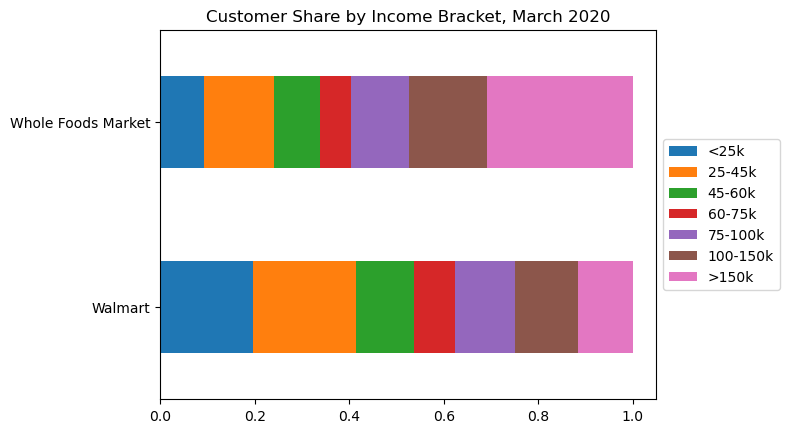

In [115]:
import matplotlib.pyplot as plt

f = plt.figure()

spend_agg.drop(['raw_num_customers', 'customers_sum'], axis = 1).plot(x = 'brands',
    kind = 'barh',
    stacked = True,
    title = 'Customer Share by Income Bracket, March 2020',
    mark_right = True, ylabel = "").legend(loc = "best")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig("customer_share.png", bbox_inches = "tight")


### Calculate revenue by brand

In [10]:
spend.top_category.unique()

array(['Lawn and Garden Equipment and Supplies Stores',
       'Restaurants and Other Eating Places', 'Shoe Stores',
       'Clothing Stores',
       'General Merchandise Stores, including Warehouse Clubs and Supercenters',
       'Postal Service', 'Gasoline Stations', 'Department Stores',
       'Grocery Stores', 'Building Material and Supplies Dealers',
       'Machinery, Equipment, and Supplies Merchant Wholesalers',
       'Other Amusement and Recreation Industries',
       'Office Supplies, Stationery, and Gift Stores',
       'Sporting Goods, Hobby, and Musical Instrument Stores',
       'Automotive Parts, Accessories, and Tire Stores',
       'Traveler Accommodation', 'Automotive Repair and Maintenance',
       'Services to Buildings and Dwellings', 'Automobile Dealers',
       'Health and Personal Care Stores', 'General Rental Centers',
       'Used Merchandise Stores', 'Personal Care Services',
       'Furniture Stores', 'Motion Picture and Video Industries',
       'Specialty

In [16]:
category_list =  ["Grocery Stores", 'Grocery and Related Product Merchant Wholesalers', 
                  "General Merchandise Stores, including Warehouse Clubs and Supercenters", 
                  ]
rev = spend[spend.top_category.isin(category_list)].groupby("brands").agg({"raw_total_spend": "sum"}).reset_index()

In [17]:
# sort rev by raw_total_spend
rev = rev.sort_values("raw_total_spend", ascending = False)
rev.to_csv('grocery_stores_by_spend.csv', index = False)

In [19]:
spend[spend.brands.isin(rev.brands)].shape

(78008, 47)

### Calculate worker income shares

In [119]:
temp = pd.json_normalize(patterns['visitor_work_cbgs'].map(eval))


In [15]:
spend[spend.brands.isin(rev.brands)].shape

(36651, 47)

In [7]:

### get mobiity data

# read poi data with suitable codec
poi = pd.read_csv(os.path.join("~/Downloads", "core_poi-part1.csv"), compression = "gzip")

# read poi data different encoding

#places = pd.read_csv("/Users/davidvandijcke/Downloads/core_poi-part1.csv")

#spend = pd.read_csv('data/spend/data/in/y=')




### have a look at walmart

In [8]:
poi.head()

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,iso_country_code,phone_number,open_hours,category_tags
0,sg:001341fe7e794ab6bd65bb80759a1ac6,NaN,Old Firehouse School,NaN,NaN,Child Day Care Services,Child Day Care Services,624410.0,37.890739,-122.118320,984 Moraga Rd,Lafayette,CA,94549,US,1.925284e+10,"{ ""Mon"": [[""8:00"", ""17:30""]], ""Tue"": [[""8:00"",...",NaN
1,sg:002921847f104c93a6df47bb831dedd2,NaN,Tenth Avenue Park,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,42.255103,-89.085241,825 10th St,Rockford,IL,61104,US,NaN,NaN,NaN
2,sg:002d2e9f047d47ca8661abb8939096cf,NaN,Hunter Village Wines & Liquors,NaN,NaN,"Beer, Wine, and Liquor Stores","Beer, Wine, and Liquor Stores",445310.0,42.214633,-74.220827,7261 Rt 23a,Hunter,NY,12442,US,1.518263e+10,"{ ""Mon"": [], ""Tue"": [[""13:00"", ""18:00""]], ""Wed...",NaN
3,sg:0060616e5f184585a026a0b7e8192fbd,NaN,Fat Moe's,NaN,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,40.948824,-74.154553,204 Diamond Bridge Ave,Hawthorne,NJ,7506,US,1.973949e+10,NaN,"Mediterranean Food,Smoothie & Juice Bar,Sandwi..."
4,sg:0061c1d8e124406cbcc97e40eb1dd585,NaN,Jungle Rapids Family Fun Park,NaN,NaN,Amusement Parks and Arcades,Amusement and Theme Parks,713110.0,34.207249,-77.863010,5320 Oleander Dr,Wilmington,NC,28403,US,1.910791e+10,NaN,NaN


In [122]:
social = pd.read_csv("/Users/davidvandijcke/Dropbox (University of Michigan)/dynamic/repo/data/safegraph/social-distancing/2020/03/02/2020-03-02-social-distancing.csv.gz", compression = "gzip")

In [123]:
social.head()

,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,bucketed_distance_traveled,median_dwell_at_bucketed_distance_traveled,completely_home_device_count,median_home_dwell_time,bucketed_home_dwell_time,at_home_by_each_hour,part_time_work_behavior_devices,full_time_work_behavior_devices,destination_cbgs,delivery_behavior_devices,median_non_home_dwell_time,candidate_device_count,bucketed_away_from_home_time,median_percentage_time_home,bucketed_percentage_time_home
0,10139533002,2020-03-02T00:00:00-06:00,2020-03-03T00:00:00-06:00,66,21964.0,"{""16001-50000"":21,""0"":8,"">50000"":14,""2001-8000...","{""16001-50000"":21,"">50000"":49,""<1000"":102,""200...",4,736,"{""721-1080"":20,""361-720"":14,""61-360"":7,""<60"":1...","[40,44,41,43,41,42,31,23,17,20,20,20,20,15,17,...",6,5,"{""011010053021"":1,""011310348002"":1,""0103996170...",1,196,108,"{""21-45"":6,""481-540"":5,""541-600"":1,""721-840"":2...",71,"{""0-25"":6,""76-100"":32,""51-75"":18,""26-50"":6}"
1,10210601014,2020-03-02T00:00:00-06:00,2020-03-03T00:00:00-06:00,177,5394.0,"{""16001-50000"":31,""0"":27,"">50000"":26,""2001-800...","{""16001-50000"":47,"">50000"":60,""<1000"":133,""200...",28,661,"{""721-1080"":49,""361-720"":30,""61-360"":19,""<60"":...","[103,106,109,110,111,106,97,83,55,52,47,43,40,...",32,20,"{""120990015001"":1,""120110302021"":1,""0107301110...",8,293,305,"{""21-45"":8,""481-540"":18,""541-600"":8,""46-60"":6,...",63,"{""26-50"":17,""51-75"":47,""0-25"":42,"">100"":3,""76-..."
2,10950303005,2020-03-02T00:00:00-06:00,2020-03-03T00:00:00-06:00,93,9340.0,"{""16001-50000"":21,""0"":15,"">50000"":8,""2001-8000...","{""16001-50000"":65,"">50000"":113,""<1000"":57,""200...",13,708,"{""721-1080"":29,""361-720"":15,""61-360"":11,""<60"":...","[58,59,59,57,56,52,50,34,25,22,23,20,19,19,17,...",14,10,"{""011030051012"":2,""010950303004"":6,""1321301040...",3,314,153,"{""21-45"":3,""481-540"":6,""541-600"":4,""46-60"":1,""...",65,"{""26-50"":7,""51-75"":28,""0-25"":20,"">100"":3,""76-1..."
3,11010055032,2020-03-02T00:00:00-06:00,2020-03-03T00:00:00-06:00,100,8172.0,"{""16001-50000"":19,""0"":18,"">50000"":7,""2001-8000...","{""16001-50000"":64,"">50000"":19,""<1000"":290,""200...",19,683,"{""721-1080"":22,""361-720"":27,""61-360"":7,""<60"":2...","[73,70,70,69,68,67,64,54,28,32,27,28,30,28,31,...",24,10,"{""011010053021"":2,""011010054033"":1,""0110100560...",2,241,159,"{""21-45"":4,""481-540"":1,""541-600"":8,""46-60"":3,""...",69,"{""0-25"":20,""76-100"":43,""51-75"":29,""26-50"":11}"
4,40210002061,2020-03-02T00:00:00-07:00,2020-03-03T00:00:00-07:00,579,10963.0,"{""16001-50000"":148,""0"":158,"">50000"":45,""2001-8...","{""16001-50000"":71,"">50000"":49,""<1000"":106,""200...",157,713,"{""721-1080"":136,""361-720"":101,""61-360"":71,""<60...","[357,352,353,353,355,350,329,271,234,215,203,2...",70,41,"{""040134226322"":2,""040210002041"":39,""040138163...",17,139,1003,"{""21-45"":25,""481-540"":26,""541-600"":27,""46-60"":...",76,"{""26-50"":37,""51-75"":133,""0-25"":111,"">100"":14,""..."


In [124]:
old = pd.read_csv("/Users/davidvandijcke/Dropbox (University of Michigan)/dynamic/repo/data/safegraph/monthly-patterns/2020/01/patterns-part1.csv.gz", compression = "gzip")

In [129]:
old.columns

Index(['safegraph_place_id', 'location_name', 'street_address', 'city',
       'region', 'postal_code', 'brands', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_work_cbgs', 'visitor_country_of_origin',
       'distance_from_home', 'median_dwell', 'bucketed_dwell_times',
       'related_same_day_brand', 'related_same_month_brand',
       'popularity_by_hour', 'popularity_by_day', 'device_type',
       'iso_country_code'],
      dtype='object')